Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ImageTransferLearning import *

train_loader, test_loader = dataloaderSetup()

Example for image and label size

In [2]:
image, label = next(iter(train_loader))
print(f"batch shape of images: {image.size()}")
print(f"batch shape of labels: {label.size()}")

batch shape of images: torch.Size([3, 3, 224, 224])
batch shape of labels: torch.Size([3])


Examples for 4 batches from the training datasetloader



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

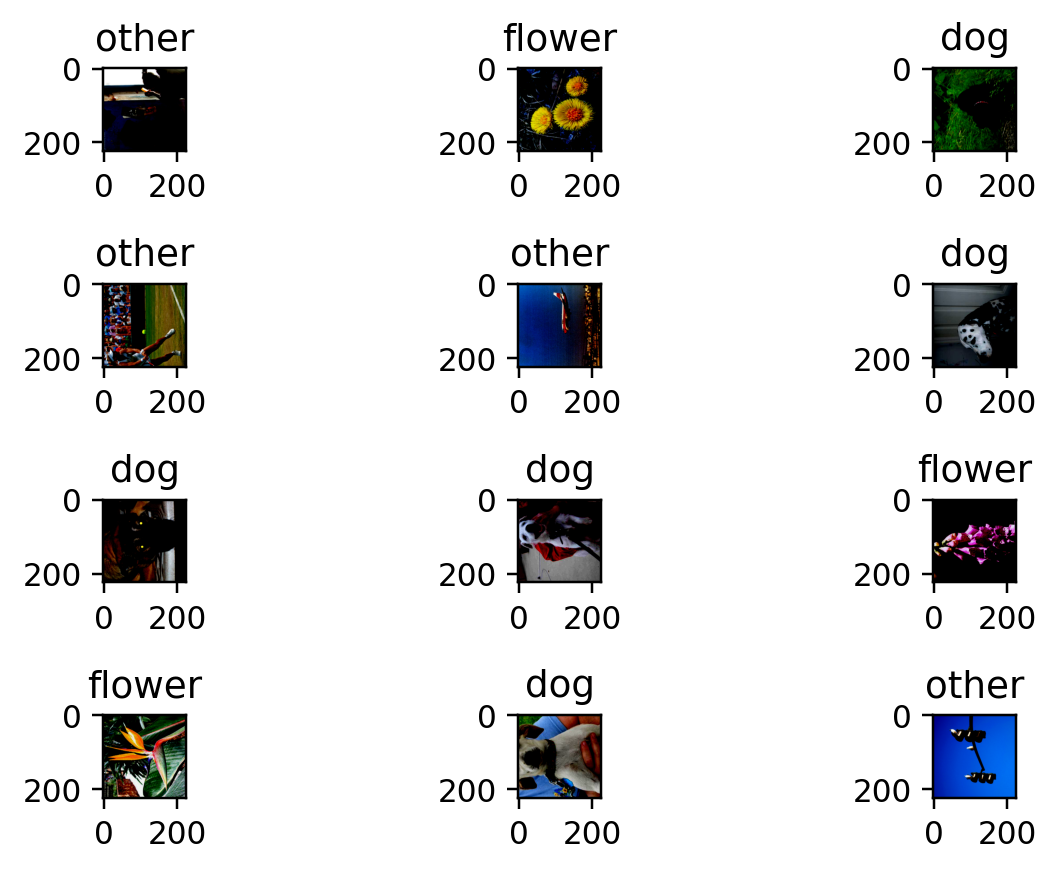

In [3]:
columns = 3
rows = 4
fig, ax = plt.subplots(rows, columns, dpi=224)
ax = ax.ravel()
for i, (image, labels) in enumerate(train_loader):
    if(i == rows):
        break
    for j, (img) in enumerate(image):
        np_array = img.numpy()
        np_array = np_array.swapaxes(0, 2)
        ax[i*columns+j].imshow(np_array)
        ax[i*columns+j].set_title(all_classes[labels[j]]) # set title
fig.tight_layout()
plt.show()

In [4]:
device = "dml"
model = neuralNetSetup().to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Confusion matrix examples from training

C:\Users\matri\miniconda3\envs\pydml\lib\site-packages\PIL\TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [1/1], Step [1040/10400], Accuracy: 0.7558, Loss: 0.0039                                                  

Epoch [1/1], Step [2080/10400], Accuracy: 0.8093, Loss: 3.5357                                                  

Epoch [1/1], Step [3120/10400], Accuracy: 0.8247, Loss: 0.8148                                                  

Epoch [1/1], Step [4160/10400], Accuracy: 0.8038, Loss: 0.0262                                                  

Epoch [1/1], Step [5200/10400], Accuracy: 0.8032, Loss: 0.7253                                                  

Epoch [1/1], Step [6240/10400], Accuracy: 0.8074, Loss: 0.0000                                                  

Epoch [1/1], Step [7280/10400], Accuracy: 0.8067, Loss: 0.6752                                                  

Epoch [1/1], Step [8320/10400], Accuracy: 0.8234, Loss: 0.0000                                                  

Epoch [1/1], Step [9360/10400], Accuracy: 0.8109, Loss: 0.9183                          

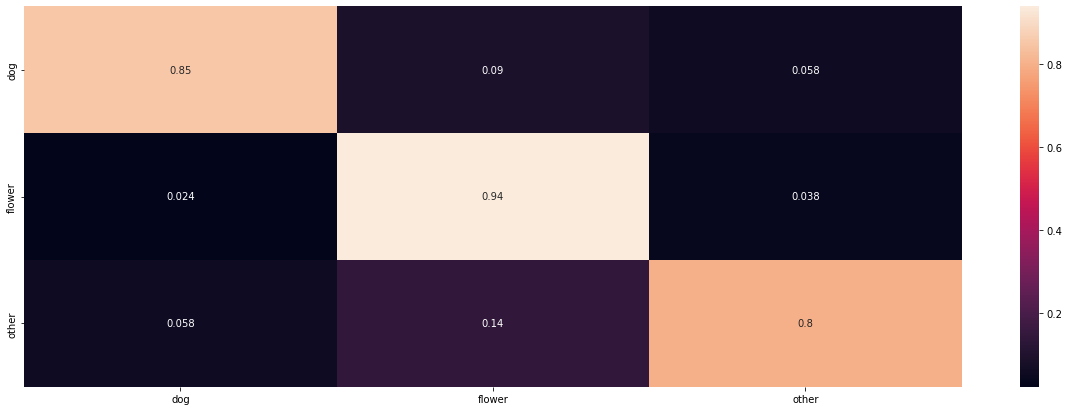

In [5]:
num_epochs = 1

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model = trainingPhase(model, criterion, optimizer, train_loader, num_epochs, 0.1, 0, device, confusionmatrixdevice, writer, FILE, all_classes, 0)

Confusion matrix examples from testing



Starting with Testing!

Creating Confusion Matrix ...
[████████████████████████████████████████████████████████████] 100.0% ...remaining Time: 0.7s


###########################Examples for wrong predictions##################################

predicted: tensor([2, 1, 1], device='dml')
labels: tensor([0, 0, 0], device='dml')
Wrong

predicted: tensor([2, 1, 1], device='dml')
labels: tensor([0, 0, 0], device='dml')
Wrong

predicted: tensor([2, 1, 1], device='dml')
labels: tensor([0, 0, 0], device='dml')
Wrong

predicted: tensor([0, 2, 1], device='dml')
labels: tensor([0, 0, 0], device='dml')
Wrong

predicted: tensor([0, 2, 1], device='dml')
labels: tensor([0, 0, 0], device='dml')
Wrong

predicted: tensor([0, 1, 2], device='dml')
labels: tensor([0, 0, 0], device='dml')
Wrong

predicted: tensor([0, 1, 2], device='dml')
labels: tensor([0, 0, 0], device='dml')
Wrong

predicted: tensor([0, 1, 2], device='dml')
labels: tensor([0, 0, 0], device='dml')
Wrong

predicted: tensor([0, 1, 2], device

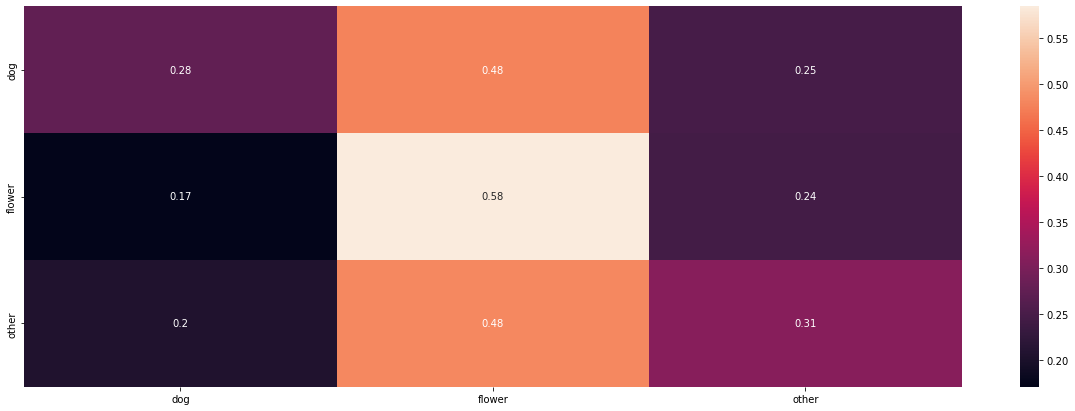

In [6]:
testingPhase(model, test_loader, writer, FILE, all_classes, 0, confusionmatrixdevice)